    1. Считайте файл и создайте Spark DataFrame.

In [1]:
from pyspark.sql import SparkSession

# Создаем SparkSession
spark = SparkSession.builder.appName("CSV to DataFrame").getOrCreate()


csv_file_path = "130/3/3.csv"

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


df.show()

df.printSchema()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---+------+
|         feature_1|         feature_2|         feature_3|         feature_4|         feature_5|         feature_6|         feature_7|         feature_8|         feature_9|        feature_10|        feature_11|        feature_12|        feature_13|        feature_14| id|target|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---+------+
|  53.2280822175126| 62.45412602621512| 37.38038285416055|  40.4822456827154| 65.98679164045055| 64.60501882017294| 63.96817677960044|58.909059124160116|  70.40439

2. Подготовьте данные для дальнейше работы.


In [2]:
from pyspark.sql.functions import col, mean


df.describe().show()


# Заполнение пропущенных значений средним по колонке
columns = df.columns

for column in columns:
    if df.schema[column].dataType.typeName == 'double':
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.fillna(column = mean_value)

df.show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|         feature_1|         feature_2|         feature_3|         feature_4|         feature_5|         feature_6|         feature_7|         feature_8|         feature_9|        feature_10|        feature_11|        feature_12|        feature_13|        feature_14|                id|             target|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              1112|              1112|        

  3. Рассчитайте и выведите матрицу корреляций для признаков.

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np


columns_to_drop = ["id","target"]

features = df.drop(*columns_to_drop)

assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
assembled_df = assembler.transform(df)

correlation_matrix = Correlation.corr(assembled_df, "features", method="pearson").collect()[0][0].toArray()

columns = features.columns

correlation_matrix = np.array(correlation_matrix)

pd_corr_matrix = pd.DataFrame(correlation_matrix, columns=columns)

pd_corr_matrix



,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14
0,1.000000,-0.024264,-0.035201,-0.017505,0.004752,0.032077,-0.015399,-0.007073,0.021694,0.004848,0.022576,0.047625,-0.013837,0.019090
1,-0.024264,1.000000,-0.049307,0.010406,0.012705,0.028966,-0.016133,-0.071109,0.026366,0.019630,-0.006540,0.043073,0.009247,-0.004766
2,-0.035201,-0.049307,1.000000,-0.016719,-0.047594,-0.006915,-0.038015,0.026483,-0.013838,0.006085,-0.003877,-0.031423,0.035680,-0.044803
3,-0.017505,0.010406,-0.016719,1.000000,-0.047122,-0.004525,0.020906,0.005442,-0.005223,0.034518,-0.017046,0.021535,0.001805,-0.025341
4,0.004752,0.012705,-0.047594,-0.047122,1.000000,-0.024522,0.046579,0.013331,0.017132,-0.003727,0.037422,0.031642,-0.054160,-0.011548
5,0.032077,0.028966,-0.006915,-0.004525,-0.024522,1.000000,-0.016258,-0.002211,0.008238,0.024668,0.002850,-0.020806,-0.016118,0.005823
6,-0.015399,-0.016133,-0.038015,0.020906,0.046579,-0.016258,1.000000,0.008274,-0.060657,0.006986,-0.059992,-0.006065,0.000684,-0.006070
7,-0.007073,-0.071109,0.026483,0.005442,0.013331,-0.002211,0.008274,1.000000,-0.008732,-0.036151,0.017049,-0.006169,0.009442,0.019356
8,0.021694,0.026366,-0.013838,-0.005223,0.017132,0.008238,-0.060657,-0.008732,1.000000,0.028855,0.058232,0.052841,-0.014566,0.038678
9,0.004848,0.019630,0.006085,0.034518,-0.003727,0.024668,0.006986,-0.036151,0.028855,1.000000,0.002692,-0.001318,-0.006490,-0.005389


4. Постройте диаграмму типа Scatter для визуализации корреляционных связей.

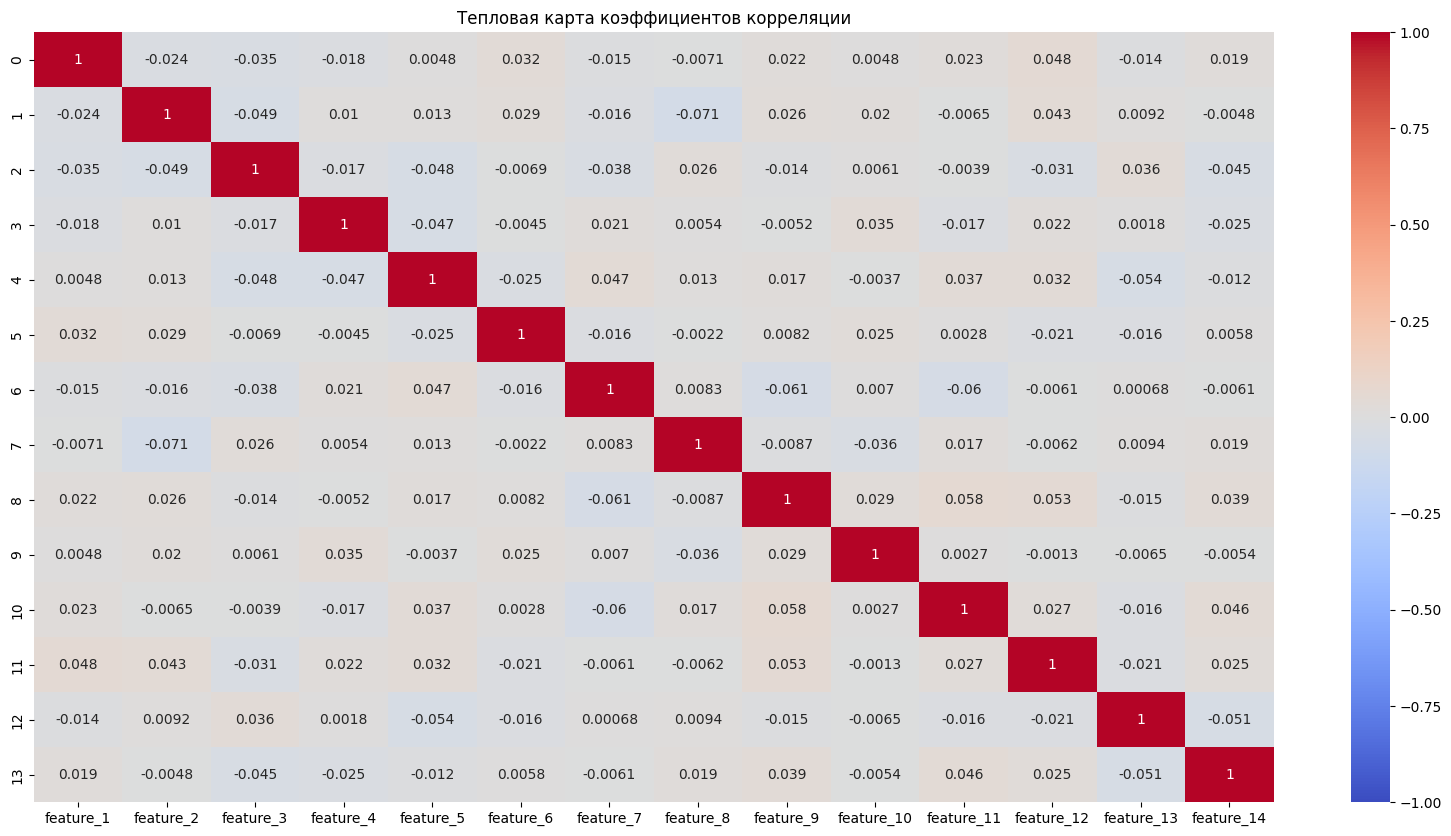

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.heatmap(pd_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Тепловая карта коэффициентов корреляции')
plt.show()


5. Запишите полученные данные в файл (п. 3).

In [ ]:

file_path = "130/3/statistic.json"

pd_corr_matrix.to_json(file_path)